# This project for classification practice
# Data Wrangle
* Explore and look at data
* check for shape, missing data, and characteristics
* Initiative to determine if a mushroom is edible or not via looking at its characteristics

In [35]:
# import packages

import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import klib
import plotly.figure_factory as ff
from IPython.core.display import display
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib
# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
#np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

In [2]:
# useful functions
def get_adjusted_cramers_v(contingency_table):
    """ variation of cramers v that adjusts for bias
    via using a smaller mean-squared error.
    It calculates and returns this statistic"""

    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    number_of_obs = np.sum(contingency_table).sum()
    phi2 = chi2 / number_of_obs
    phi2_adjusted = max(0, phi2 - dof/(number_of_obs-1))
    row, column = contingency_table.shape
    row_adjusted = row - ((row-1)**2)/(number_of_obs-1)
    column_adjusted = column - ((column-1)**2)/(number_of_obs-1)
    mini_adjusted = min(row_adjusted, column_adjusted)-1

    cramers_v_adjusted = np.sqrt(phi2_adjusted / mini_adjusted)
    return cramers_v_adjusted

def get_cramers_v(contingency_table):
    """ variation of cramers v that adjusts for bias
    via using a smaller mean-squared error.
    It calculates and returns this statistic"""

    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    number_of_obs = np.sum(contingency_table).sum()
    phi2 = chi2 / number_of_obs
    # phi2_adjusted = max(0, phi2 - dof/(number_of_obs-1))
    row, column = contingency_table.shape
    mini = min(row, column)-1

    cramers_v = np.sqrt(phi2 / mini)
    return cramers_v

In [3]:
path = r'../../data/raw/mushrooms.csv'

mushroom = pd.read_csv(path)
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
mushroom.shape, mushroom.isnull().sum()

((8124, 23),
 class                       0
 cap-shape                   0
 cap-surface                 0
 cap-color                   0
 bruises                     0
 odor                        0
 gill-attachment             0
 gill-spacing                0
 gill-size                   0
 gill-color                  0
 stalk-shape                 0
 stalk-root                  0
 stalk-surface-above-ring    0
 stalk-surface-below-ring    0
 stalk-color-above-ring      0
 stalk-color-below-ring      0
 veil-type                   0
 veil-color                  0
 ring-number                 0
 ring-type                   0
 spore-print-color           0
 population                  0
 habitat                     0
 dtype: int64)

* The classes for the data appear to be poisonous, edible, so it appears to be binary like
* We have 8k rows and 23 columns
* There is no perceivable missing data but need to check whether any erratic data

In [5]:
mushroom.info(), mushroom.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

(None,
        class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
 count   8124      8124        8124      8124    8124  8124            8124   
 unique     2         6           4        10       2     9               2   
 top        e         x           y         n       f     n               f   
 freq    4208      3656        3244      2284    4748  3528            7914   
 
        gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
 count          8124      8124       8124  ...                     8124   
 unique            2         2         12  ...                        4   
 top               c         b          b  ...                        s   
 freq           6812      5612       1728  ...                     4936   
 
        stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
 count                    8124                   8124      8124       8124   
 unique                      9                      9         1

* the data type needs to be converted to string or text
* perhaps improve readability for folder would helpful for future purposes
* to check any errors on data, need to check columns for unique values


In [6]:
# get max length of characters used for column names
mush_col = mushroom.columns

# convert each column to type string with given max character length
for col in mush_col:
    mushroom[col] = mushroom[col].astype('string')

# display converted column types to string
mushroom.dtypes

class                       string
cap-shape                   string
cap-surface                 string
cap-color                   string
bruises                     string
odor                        string
gill-attachment             string
gill-spacing                string
gill-size                   string
gill-color                  string
stalk-shape                 string
stalk-root                  string
stalk-surface-above-ring    string
stalk-surface-below-ring    string
stalk-color-above-ring      string
stalk-color-below-ring      string
veil-type                   string
veil-color                  string
ring-number                 string
ring-type                   string
spore-print-color           string
population                  string
habitat                     string
dtype: object

In [7]:
# with open('../../data/raw/opafy19nid/opafy19nid.dat') as f:
#     # next(f)
#     tmp = pd.DataFrame(l.rstrip().split() for l in f)
# print(tmp)

In [8]:
mushroom.nunique()

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64

* we can look at documentation for names for each labeled values

In [9]:
# use to check if any values explain missingness
for count, col in enumerate(mush_col):
    print(count, col, mushroom[col].unique(), '\n')

0 class <StringArray>
['p', 'e']
Length: 2, dtype: string 

1 cap-shape <StringArray>
['x', 'b', 's', 'f', 'k', 'c']
Length: 6, dtype: string 

2 cap-surface <StringArray>
['s', 'y', 'f', 'g']
Length: 4, dtype: string 

3 cap-color <StringArray>
['n', 'y', 'w', 'g', 'e', 'p', 'b', 'u', 'c', 'r']
Length: 10, dtype: string 

4 bruises <StringArray>
['t', 'f']
Length: 2, dtype: string 

5 odor <StringArray>
['p', 'a', 'l', 'n', 'f', 'c', 'y', 's', 'm']
Length: 9, dtype: string 

6 gill-attachment <StringArray>
['f', 'a']
Length: 2, dtype: string 

7 gill-spacing <StringArray>
['c', 'w']
Length: 2, dtype: string 

8 gill-size <StringArray>
['n', 'b']
Length: 2, dtype: string 

9 gill-color <StringArray>
['k', 'n', 'g', 'p', 'w', 'h', 'u', 'e', 'b', 'r', 'y', 'o']
Length: 12, dtype: string 

10 stalk-shape <StringArray>
['e', 't']
Length: 2, dtype: string 

11 stalk-root <StringArray>
['e', 'c', 'b', 'r', '?']
Length: 5, dtype: string 

12 stalk-surface-above-ring <StringArray>
['s', 'f', '

* column 11, stalk-root has a missing value column ?
* next need to check how how many ? values in column 11
* Also veil type only has one distinct value and has no use so we will just drop this for now

In [10]:
# drop low variance column
mushroom.drop('veil-type', axis=1, inplace=True)
mush_col = mushroom.columns
mush_col

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [11]:
# reformat names to more interpreted labels
mapping = { 'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 'x': 'sunken'},
            'cap-surface': {'s': 'smooth', 'f': 'fibrous', 'g': 'grooves', 'y': 'scaly'},
            'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p':'pink',
                          'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
            'bruises': {'t': 'bruises', 'f': 'no'},
            'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty',
                     'n': 'none', 'p': 'pungent', 's': 'spicy'},
            'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free','n': 'notched'},
            'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
            'gill-size': {'b': 'broad', 'n': 'narrow'},
            'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green',
                           'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
            'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
            'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup','e': 'equal', 'z': 'rhizomorphs',
                           'r': 'rooted', '?': 'missing'},
            'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
            'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
            'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange',
                                       'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
            'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange',
                                       'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
            'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
            'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
            'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none',
                          'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
            'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green',
                                  'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
            'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered',
                           'v': 'several', 'y': 'solitary'},
            'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'd': 'woods', 'p': 'paths',
                        'u': 'urban', 'w': 'waste'},
            'class': {'e': 'edible', 'p':'poisonous'}
          }
mushroom.replace(mapping, inplace = True)
mushroom.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,sunken,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
1,edible,sunken,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,meadows
3,poisonous,sunken,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
4,edible,sunken,smooth,gray,no,none,free,crowded,broad,black,...,smooth,smooth,white,white,white,one,evanescent,brown,abundant,grasses


In [12]:
# mushroom['stalk-root'].loc[mushroom['stalk-root'].str.contains('?')].count()
number_of_missing = mushroom['stalk-root'].loc[mushroom['stalk-root'] == 'missing'].count()
print(len(mushroom), number_of_missing, number_of_missing / len(mushroom))

8124 2480 0.3052683407188577


* There are 2480 missing values
* That means 30% of data has a missing value which means we shouldn't just drop it ( > 2%)
* check if there is a pattern among missing values and other features


* Perform test to determine what type of missingness
Ho = There is no association between missingness in the stalk-root column and the other columns (where crit p = 0.05)

* run test to determine if randomness is due to mcar

In [13]:
# this dataframe contains all columns with missing values
# now run a contingency chi square test with columns to see if there is an dependence
missing_stalks = mushroom.loc[mushroom['stalk-root'] == 'missing']

In [14]:
# make a column for missing and nonmissing data
missing_stalk_roots = [val  if val == 'missing' else 'non-missing' for val in mushroom['stalk-root']]

mushroom.insert(12, 'missing_stalk_roots', missing_stalk_roots)
mushroom.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,sunken,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
1,edible,sunken,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,meadows
3,poisonous,sunken,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
4,edible,sunken,smooth,gray,no,none,free,crowded,broad,black,...,smooth,smooth,white,white,white,one,evanescent,brown,abundant,grasses


In [15]:
# make a dataframe capturing the p and cramers v values
adjusted_cramers_v_values = []

for col in mush_col:
    contingency_table = pd.crosstab(mushroom['missing_stalk_roots'], mushroom[col])
    adjusted_cramers_v_values.append(get_adjusted_cramers_v(contingency_table))

In [16]:
assoc_strengths = ['Strong', 'Moderate', 'Weak', 'Very weak']

assoc_strengths_values = [assoc_strengths[0] if val > 0.5 else
                          assoc_strengths[1] if val > 0.3 else
                          assoc_strengths[2] if val > 0.1 else
                          assoc_strengths[3] for val in adjusted_cramers_v_values]

In [17]:
missing_relations = pd.DataFrame({'Mushroom Features': mush_col,
                                  'Cramers V (adjusted)':adjusted_cramers_v_values,
                                  'Associated Strength':assoc_strengths_values}).sort_values(by='Cramers V (adjusted)', ascending=False)
missing_relations.reset_index(drop=True, inplace=True)
missing_relations

,Mushroom Features,Cramers V (adjusted),Associated Strength
0,stalk-root,0.999815,Strong
1,spore-print-color,0.929691,Strong
2,gill-color,0.850809,Strong
3,ring-type,0.646817,Strong
4,odor,0.640680,Strong
5,gill-size,0.601792,Strong
6,habitat,0.594037,Strong
7,cap-color,0.506855,Strong
8,population,0.499297,Moderate
9,cap-shape,0.480141,Moderate


In [18]:
# drop stalk root as it is obvious we get a dpeendent relation compared to missing stalk root features (as it was derived from that prior feature)
missing_relations.drop(0, inplace=True)

Text(0.5, 1.0, 'Top Associated Strength of Mushroom Features on Missing Stalk Root')

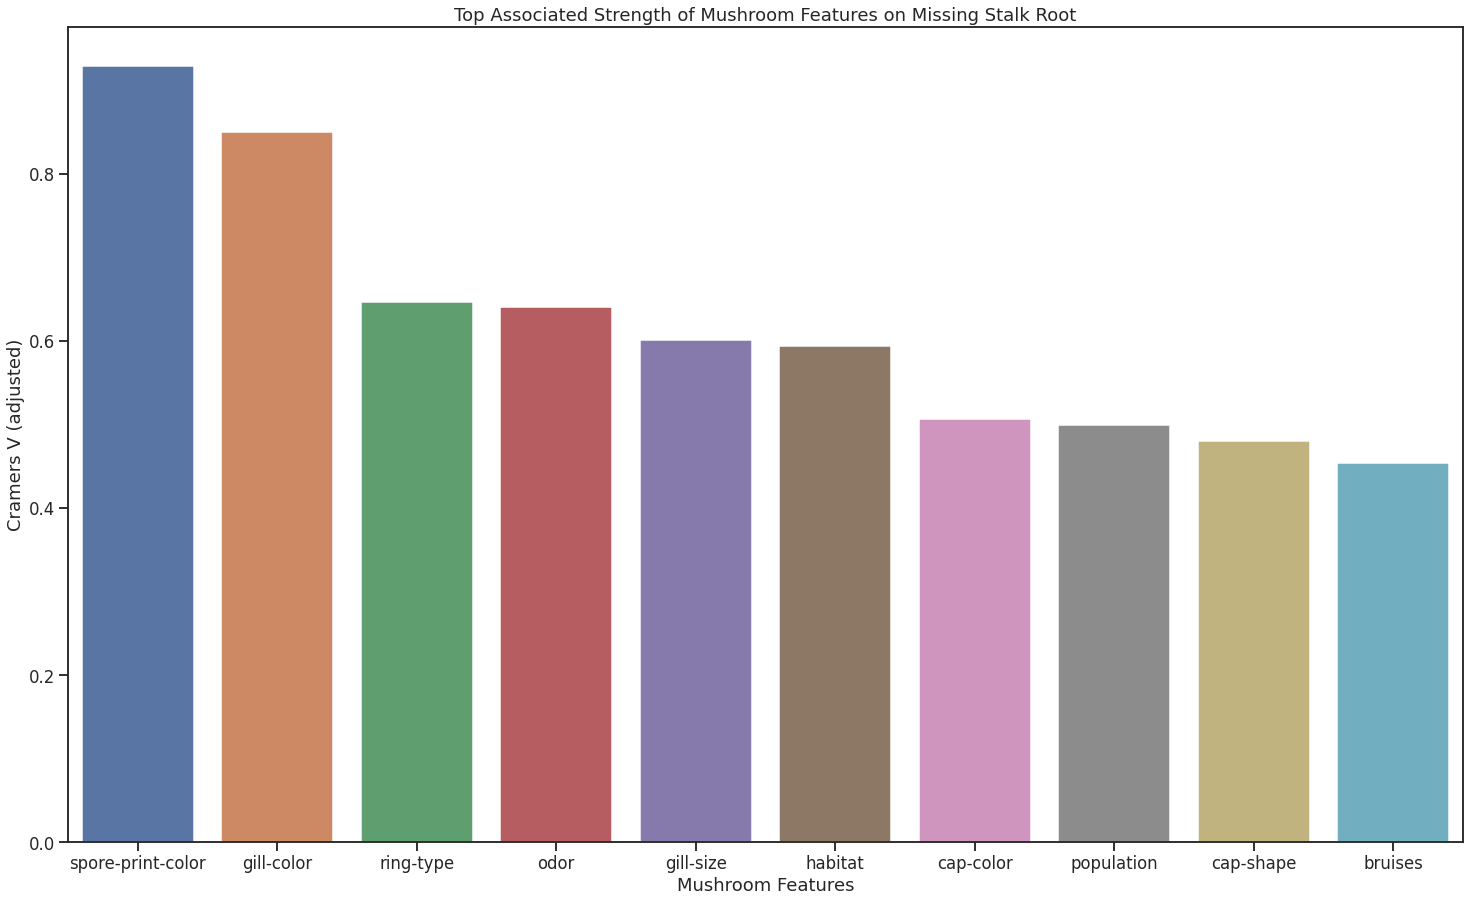

In [19]:
plt.figure(figsize=(25,15))
sns.barplot(data=missing_relations[:10], x='Mushroom Features', y='Cramers V (adjusted)')
plt.title('Top Associated Strength of Mushroom Features on Missing Stalk Root')

From the interpretation of Cramers V statistic of our missing column with other columns
it is shown that the missing value is most likely not due to randomness and so the type
of missingness; it is not MCAR.
Also we had 16 columns that deem a strong relationship with the missing column
We can perform some imputation to predict values for the missing value.

# Predict and impute missing data
* Separate dataframe from missing and non missing data
* preprocess the known data
* split known data
* perform random forest regressor to train and get score
* use this model to predict our missing data values

In [20]:
# drop mushroom missing column as we no longer need it
mushroom.drop('missing_stalk_roots', axis=1, inplace=True)
'missing_stalk_roots' in mushroom.columns

False

In [21]:
# separate known and unknown data
unknown_stalk = mushroom['stalk-root'] == 'missing'

known_mushroom = mushroom.loc[~unknown_stalk]
display(known_mushroom)

unknown_mushroom = mushroom.loc[unknown_stalk]
display(unknown_mushroom)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,sunken,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
1,edible,sunken,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,meadows
3,poisonous,sunken,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
4,edible,sunken,smooth,gray,no,none,free,crowded,broad,black,...,smooth,smooth,white,white,white,one,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7986,edible,bell,scaly,brown,no,none,free,close,broad,white,...,scaly,scaly,brown,brown,white,two,pendant,white,solitary,paths
8001,edible,sunken,scaly,brown,no,none,free,close,broad,white,...,scaly,scaly,brown,brown,white,two,pendant,white,solitary,paths
8038,edible,sunken,scaly,gray,bruises,none,free,close,broad,white,...,smooth,smooth,white,white,white,two,pendant,white,solitary,paths
8095,poisonous,sunken,scaly,cinnamon,no,musty,free,close,broad,yellow,...,silky,scaly,cinnamon,cinnamon,white,none,none,white,clustered,woods


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3984,edible,sunken,scaly,buff,bruises,none,free,close,broad,red,...,smooth,smooth,red,white,white,two,evanescent,white,clustered,waste
4023,poisonous,sunken,scaly,red,no,fishy,free,close,narrow,buff,...,silky,smooth,white,white,white,one,evanescent,white,several,paths
4076,edible,flat,scaly,purple,no,none,free,close,narrow,chocolate,...,smooth,fibrous,white,white,white,one,flaring,chocolate,solitary,woods
4100,poisonous,sunken,scaly,red,no,fishy,free,close,narrow,buff,...,silky,smooth,pink,pink,white,one,evanescent,white,several,woods
4104,poisonous,sunken,scaly,brown,no,foul,free,close,narrow,buff,...,smooth,smooth,pink,pink,white,one,evanescent,white,several,leaves
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,edible,knobbed,smooth,brown,no,none,attached,close,broad,yellow,...,smooth,smooth,orange,orange,orange,one,pendant,buff,clustered,leaves
8120,edible,sunken,smooth,brown,no,none,attached,close,broad,yellow,...,smooth,smooth,orange,orange,brown,one,pendant,buff,several,leaves
8121,edible,flat,smooth,brown,no,none,attached,close,broad,brown,...,smooth,smooth,orange,orange,orange,one,pendant,buff,clustered,leaves
8122,poisonous,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,...,smooth,silky,white,white,white,one,evanescent,white,several,leaves


### Preprocessing
We are using a label encoder even though the categories are not ordinal.
This is due to the fact that we will be using a tree model and tree models have a behavior
to perform well with label encoders even when no ordering relationship is present
Also save time in not needing to perform one hot encoding and then pca

In [22]:
# preprocess known mushrooms
# also drop class (due to data leakage later in notebook)
X = known_mushroom.drop(['stalk-root', 'class'], axis=1)
y = known_mushroom['stalk-root']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
X_cols = X_train.columns

le_X = LabelEncoder()
le_y = LabelEncoder()

for col in X_cols:
    # encode X_train and fit X_test on that encoder
    X_train[col] = le_X.fit_transform(X_train[col])
    X_test[col] = le_X.transform(X_test[col])

# encode y_train and fit y_test on that encoder
y_train = le_y.fit_transform(y_train)
y_test = le_y.transform(y_test)


In [25]:
rf_pipe = Pipeline([('rf', RandomForestClassifier(random_state=42))])
rf_param_grid = {}

In [26]:
rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={})

In [31]:
train_std = rf_grid.cv_results_['std_test_score'][rf_grid.best_index_]
train_score, test_score = rf_grid.best_score_, rf_grid.score(X_test, y_test)

In [32]:
print('train score:', train_score, 'train std score:', train_std, 'test score:', test_score)

train score: 1.0 train std score: 0.0 test score: 1.0


In [37]:
# save rf_model_for_imputataion
rf_model_for_imputation = rf_grid.best_estimator_
model_path = r'../../model/rf_model_for_imputation.sav'

joblib.dump(rf_model_for_imputation, model_path)

['../../model/rf_model_for_imputation.sav']

# evaluation
With the amount of data and strong correlations from earlier I am not as surprised that we are able to score a 100% accuracy
* default scoring of accuracy metric was used for random forest
